In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn

from torchmeta.datasets.helpers import omniglot
from torchmeta.datasets import Omniglot
from torchmeta.utils.data import BatchMetaDataLoader
import matplotlib.pyplot as plt

from dotted.utils import dot
import hypernet as hn
from tqdm import tqdm
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
N, K = 5, 5

dataset = omniglot("data", ways=N, shots=K, test_shots=15, meta_train=True, download=True)
dataloader = BatchMetaDataLoader(dataset, batch_size=16, num_workers=0)

In [5]:
for T in dataloader:
    break

/home/mprzewie/.anaconda3/envs/uj/lib/python3.8/site-packages/torchvision/transforms/functional.py:942: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


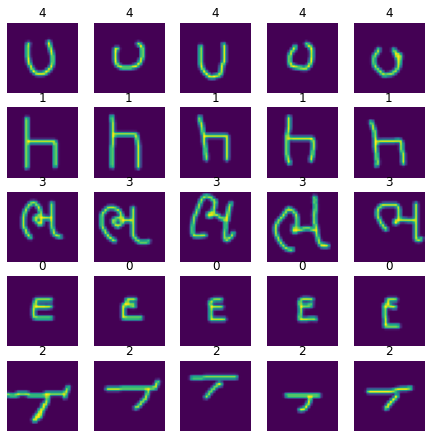

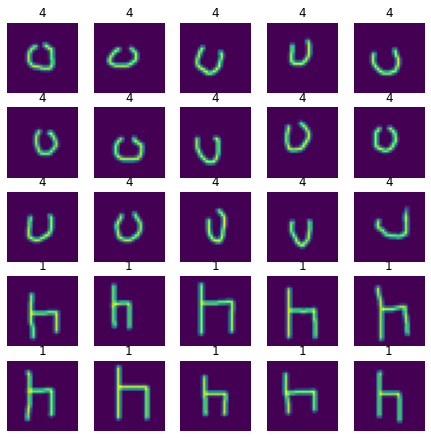

In [6]:
x, y = T["train"]
x, y = x[0], y[0]

fig, ax= plt.subplots(N, K, figsize=(1.5*K, 1.5*N,))

for n in range(N):
    for k in range(K):
        i = n*K + k
        ax[n,k].imshow(x[i].squeeze())
        ax[n,k].set_title(f"{y[i]}")
        ax[n,k].axis("off")

plt.show()

x, y = T["test"]
x, y = x[0], y[0]

fig, ax= plt.subplots(N, K, figsize=(1.5*K, 1.5*N,))

for n in range(N):
    for k in range(K):
        i = n*K + k
        ax[n,k].imshow(x[i].squeeze())
        ax[n,k].set_title(f"{y[i]}")
        ax[n,k].axis("off")


In [7]:
target_net = nn.Sequential(
        nn.Conv2d(1, 8, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(8, 16, 3, padding=1, stride=2),
        nn.ReLU(),
        nn.Conv2d(16, 16, 3, padding=1, stride=2),
        nn.Flatten(),
        nn.Linear(7*7*16, 128),
        nn.ReLU(),
        nn.Linear(128, N)
    )



In [8]:
hypernet = hn.HyperNetwork(
    target_network=target_net,
    n=N, k=K,
    fe_out_size=128
)
hypernet.to(device)

loss_fn = nn.CrossEntropyLoss()
h_opt = torch.optim.Adam(hypernet.parameters(), lr=4e-5)
sum(p.numel() for p in hypernet.parameters())

0.weight torch.Size([8, 1, 3, 3]) 409600 9216
0.bias torch.Size([8]) 409600 1024
2.weight torch.Size([16, 8, 3, 3]) 409600 147456
2.bias torch.Size([16]) 409600 2048
4.weight torch.Size([16, 16, 3, 3]) 409600 294912
4.bias torch.Size([16]) 409600 2048
6.weight torch.Size([128, 784]) 409600 12845056
6.bias torch.Size([128]) 409600 16384
8.weight torch.Size([5, 128]) 409600 81920
8.bias torch.Size([5]) 409600 640


18148714

In [9]:
n_tasks = 0
taskset_epochs = 10


for task_set_id, tasks in enumerate(tqdm(dataloader, total=n_tasks)):
    
    for e in range(taskset_epochs):
        X_train, Y_train = tasks["train"]
        X_test, Y_test = tasks["test"]
        X_train, X_test, Y_train, Y_test = [t.to(device) for t in [X_train, X_test, Y_train, Y_test]]

        train_losses = []
        train_accs = []

        test_losses = []
        test_accs = []

#         h_opt.zero_grad()

        for t_id, (x_train, y_train, x_test, y_test) in enumerate(zip(X_train, Y_train, X_test, Y_test)):
            h_opt.zero_grad()

            target_net = hypernet(x_train)
            y_pred = target_net(x_train)

            loss = loss_fn(y_pred, y_train)
            loss.backward()
            h_opt.step()

            train_acc = (y_pred.argmax(dim=1) == y_train).sum() / len(y_train)

            train_losses.append(loss.item())
            train_accs.append(train_acc.item())

            x_test, y_test = T["test"]
            x_test, y_test = [t[t_id].to(device) for t in [x_test, y_test]]
            y_pred = target_net(x_test)
            loss = loss_fn(y_pred, y_test)

            test_acc = (y_pred.argmax(dim=1) == y_test).sum() / len(y_test)

            test_losses.append(loss.item())
            test_accs.append(test_acc.item())

#         h_opt.step()
        print(
            task_set_id, 
            e,
            {
                "tr_l": np.mean(train_losses).item(),
                "te_l": np.mean(test_losses).item(),
                "tr_a": np.mean(train_accs).item(),
                "te_a": np.mean(test_accs).item()
            } 
             )
        
    if task_set_id == n_tasks:
        break
    


0it [00:00, ?it/s]

0 0 {'tr_l': 1.6095359772443771, 'te_l': 1.6095275059342384, 'tr_a': 0.20749999023973942, 'te_a': 0.21333333477377892}
0 1 {'tr_l': 1.6075461357831955, 'te_l': 1.609793283045292, 'tr_a': 0.3099999902769923, 'te_a': 0.20833333674818277}
0 2 {'tr_l': 1.5995032414793968, 'te_l': 1.6120325475931168, 'tr_a': 0.3549999902024865, 'te_a': 0.1866666693240404}
0 3 {'tr_l': 1.5287998095154762, 'te_l': 1.6540539041161537, 'tr_a': 0.34499998996034265, 'te_a': 0.20750000653788447}
0 4 {'tr_l': 1.4103802517056465, 'te_l': 1.8358425796031952, 'tr_a': 0.377499985974282, 'te_a': 0.18500000319909304}
0 5 {'tr_l': 1.2354548685252666, 'te_l': 2.006910517811775, 'tr_a': 0.4849999900907278, 'te_a': 0.18833333579823375}
0 6 {'tr_l': 1.1033154092729092, 'te_l': 2.1344437450170517, 'tr_a': 0.5299999881535769, 'te_a': 0.210833337623626}
0 7 {'tr_l': 0.9815739952027798, 'te_l': 2.344128765165806, 'tr_a': 0.6224999763071537, 'te_a': 0.21416667010635138}
0 8 {'tr_l': 0.8103675618767738, 'te_l': 2.71662238240242, 't

0it [00:09, ?it/s]

0 9 {'tr_l': 0.6262121088802814, 'te_l': 3.0893270671367645, 'tr_a': 0.7699999827891588, 'te_a': 0.22083333786576986}
